In [0]:
!pip install torch===1.4.0 torchvision===0.5.0 -f https://download.pytorch.org/whl/torch_stable.html

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


*Setting up working directory*

In [0]:
import sys
sys.path.append('/content/drive/My Drive/Transfer_Learning_IGV_RESNET')

*Importing Required Libraries*

In [0]:
import torch.optim as optim
import torch
import torchvision
import numpy as np
import copy
import time
import sys
import matplotlib.pyplot as plt
import numpy as np

# DataLoader

In [0]:
import datahandler

In [0]:
dataloaders = datahandler.get_dataloader_single_folder('/content/drive/My Drive/Transfer_Learning_IGV_RESNET/mini_dataset', batch_size=4)

Just to note You have to change the resize factor in datahandler.py

# Model

*Using DeepLabV3 libraries and Resnet101 as pre-trained model*

In [0]:
from models.segmentation.deeplabv3 import DeepLabHead
from torchvision import models


def createDeepLabv3(outputchannels=1):
    model = models.segmentation.deeplabv3_resnet101(
        pretrained=True, progress=True)
    # Added a Sigmoid activation after the last convolution layer
    model.classifier = DeepLabHead(2048, outputchannels)
    # Set the model in training mode
    model.train()
    return model

In [0]:
model = createDeepLabv3()
model.train()

In [0]:
# Specify the loss function
criterion = torch.nn.MSELoss(reduction='mean')
# Specify the optimizer with a lower learning rate
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Training

**Model, Criterion, Dataloaders, Optimizer, num_epochs need to be passed** 

*Num_epochs = 3 is default*

In [0]:
def train_model(model, criterion, dataloaders, optimizer, num_epochs = 3):
    
    
    train_loss = 0.0
    tot_train_loss = 0.0
    step_train = 0
    step_val = 0
    min_loss = sys.maxsize
    best_model_wts = copy.deepcopy(model.state_dict())
    start = time.time()
    
    for epoch in range(num_epochs):
        
        
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        model.to(device)
        
        model.train()
    
    
        for i, data in enumerate(dataloaders['Train'], 0):
            print("Inside Train")
            step_train += 1
            image = data['image'].to(device)
            mask = data['mask'].to(device)
    
            optimizer.zero_grad()
            
            with torch.set_grad_enabled(True):
                pred_mask = model(image)
                loss = criterion(pred_mask['out'], mask)
        
                loss.backward()
                optimizer.step()      
                
    
            train_loss += loss.item()
            tot_train_loss += loss.item()
    
            if(i%4 == 3):
                print('Training Loss after ' + str(epoch + 1) + ' epochs and step ' + str(i + 1) + ' is ' + str(train_loss/4))
    
                train_loss = 0.0
    
        print('\n')
        print('Total raining loss after ' + str(epoch + 1) + ' is ' + str(tot_train_loss/(i+1)))
        print('\n')
    
        
    #===========validation==============
        
        #always note that during validation gradient descent is disabled
        with torch.no_grad():
            print("Inside Validation")
            val_loss = 0.0
            model.eval()
    
            for i, data in enumerate(dataloaders['Test'], 0):
                
                print("Inside Test")
                
                step_val += 1
                image = data['image'].cuda()
                mask = data['mask'].cuda()
                pred_mask = model(image)
                loss = criterion(pred_mask['out'], mask)
                val_loss += loss.item()
    
            val_loss = val_loss/(i + 1)
            print('Validation loss after ' + str(epoch + 1) + ' epochs is ' + str(val_loss))
    
            if val_loss < min_loss:
                
                min_loss = val_loss
                print('Improvement..........................................')
                #torch.save(model.state_dict(), 'C:\\Users\\Kamaljeet\\Desktop\\DeepLabv3FineTuning-master\\dats' + 'epoch_' + str(epoch + 1) + '_loss_' + str(val_loss) + '.pt')
                best_model_wts = copy.deepcopy(model.state_dict())
                
            else:
                
                print('No improvement>>>>>>>>>>>>>>>>>>>>>')
                
    end = time.time()    
    print(end-start)
    model.load_state_dict(best_model_wts)
    return model

### Training Function

It returns the model having weights with minimum loss for that number of epochs

In [0]:
trained_model = train_model(model, criterion, dataloaders, optimizer, num_epochs=25)

*Saving the weight file*

In [0]:
torch.save(model.state_dict(), '/content/drive/My Drive/Transfer_Learning_IGV_RESNET/best_weights_IGV.pt')

# Testing

In [0]:
model = createDeepLabv3()

Passing Some test images

torch.Size([4, 3, 256, 256])
torch.Size([4, 1, 256, 256])
torch.Size([4, 1, 256, 256])


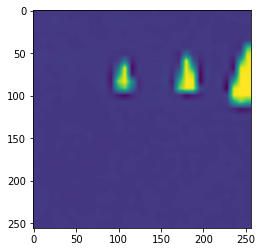

In [13]:
weight_location = '/content/drive/My Drive/Transfer_Learning_IGV_RESNET/best_weights_IGV.pt'
i = 0
for i, data in enumerate(dataloaders['Train'], 0):
    image = data['image'].cuda()
    mask = data['mask'].cuda()
    

    
    #plt.imshow(pred_mask[0,0,:,:].detach().cpu())

    with torch.set_grad_enabled(False):
        
        model = createDeepLabv3()
        state_dict = torch.load(weight_location, map_location = 'cuda:0')
        model.load_state_dict(state_dict)
        model.eval()
        model.cuda()
        pred_mask = model(image)
        
    
    #print(pred_mask)

    
    i += 1
    print(image.shape)
    print(mask.shape)
    #print(pred_mask.shape)
    #print((pred_mask['out']))
    y_pred_np = pred_mask['out'].detach().cpu()
    print(y_pred_np.shape)

    b = image.cpu().numpy()

    y_pred_np = y_pred_np*255

    a = y_pred_np[0,0,:,:]
    plt.imshow(y_pred_np[0,0,:,:].detach().cpu())

    #plt.imshow(torchvision.utils.make_grid(image.cpu()))
    
    
    if(i==1):
        break

In [0]:
weight_location = '/content/drive/My Drive/Transfer_Learning_IGV_RESNET/best_weights_IGV.pt'


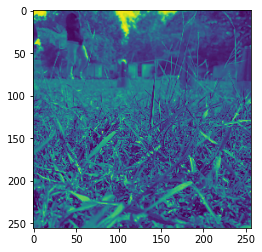

In [14]:
plt.imshow(b[0,0,:,:])